In [2]:
!pip3 install pandas


In [3]:
!pip3 install matplotlib

In [5]:
!pip3 install numpy

In [27]:
!pip3 install tensorflow

In [34]:
!pip3 install keras

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import string
import time
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense, LSTM, GRU
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping

In [70]:
data = pd.read_csv('/content/train.csv')
train = pd.read_csv('/content/train.csv')


In [71]:
data['text_len'] = data['comment_text'].apply(lambda x: len(x.split(' ')))


In [72]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,67.866962
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,100.520204
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2273.000000


(array([1.51447e+05, 5.64800e+03, 1.53200e+03, 8.66000e+02, 5.10000e+01,
        1.90000e+01, 5.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 2.2820e+02, 4.5540e+02, 6.8260e+02, 9.0980e+02,
        1.1370e+03, 1.3642e+03, 1.5914e+03, 1.8186e+03, 2.0458e+03,
        2.2730e+03]),
 <BarContainer object of 10 artists>)

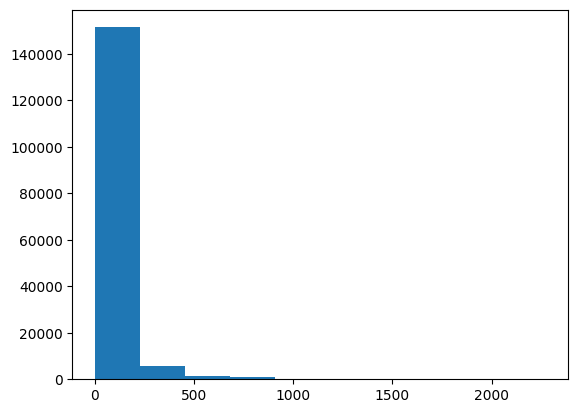

In [73]:
plt.hist(data['text_len'])

In [74]:
# Check the number of words that are covered in our dataset
count_250 = len(data.loc[data['text_len'] < 250, 'text_len'])
count_500 = len(data.loc[data['text_len'] < 500, 'text_len'])
print(count_250, count_500)

152730 157459


In [75]:
# Let's find out the frequency of word repetition in the dataset
data.loc[data['text_len'] > 1000, 'comment_text'].sample(1).values

array(['What is rong with you u pervert i ahte u just leave me alone and for ur info  i am 10 turning a 11 in one week on oct. 5 so go away i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you i hate you  i hate you i ha

In [76]:
max_features = 10000
sequence_length = 200

# Function that converts text to one form
def custom_standardization(sentence):
  sample = tf.strings.lower(sentence)
  sample = tf.strings.regex_replace(sample, '\W', ' ')
  sample = tf.strings.regex_replace(sample, '\d', ' ')
  return tf.strings.regex_replace(sample, '[%s]'%re.escape(string.punctuation), '')


In [77]:
vectorize_layer = tf.keras.layers.TextVectorization(
                        standardize=custom_standardization,
                        split='whitespace',
                        max_tokens=max_features,
                        output_mode='int',
                        output_sequence_length=sequence_length,
                        encoding='utf-8')
vectorize_layer.adapt(train['comment_text'])

In [78]:
X = train['comment_text']
Y = train[train.columns[2:-1]]
X = np.array(vectorize_layer(X))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [79]:
# We build a neural network model with long short-term memory (LSTM)
# and evaluate its running time and accuracy:

# Define the dimension of the embedding
embedding_dim = 9
# Create a Sequential model
cnn_model = Sequential()
# Add an Embedding layer
cnn_model.add(Embedding(max_features+1, embedding_dim))
# Add a Dropout layer to prevent overfitting
cnn_model.add(Dropout(0.2))
# Add a GlobalAveragePooling1D layer
cnn_model.add(GlobalAveragePooling1D())
# Add another Dropout layer
cnn_model.add(Dropout(0.2))
# Add a fully connected Dense layer with ReLU activation
cnn_model.add(Dense(16, activation='relu'))
# Add a final Dense layer with sigmoid activation for multi-label classification
cnn_model.add(Dense(6, activation='sigmoid'))

cnn_model.compile(
    # Use binary cross-entropy loss for multi-label classification
    loss='binary_crossentropy',
    # Use the Adam optimizer
    optimizer='Adam',
    # Track accuracy during training
    metrics=['accuracy']
)



In [66]:
# Number of epochs to train the LSTM model
lstm_epochs = 5
# Create a Sequential model
lstm_model = Sequential()
# Add an Embedding layer
lstm_model.add(Embedding(max_features+1, embedding_dim))
# Add an LSTM layer with 16 units
lstm_model.add(LSTM(16))
# Add a Dropout layer to prevent overfitting
lstm_model.add(Dropout(0.2))
# Add a fully connected Dense layer with ReLU activation
lstm_model.add(Dense(16, activation='relu'))
# Add a final Dense layer with sigmoid activation for multi-label classification
lstm_model.add(Dense(6, activation='sigmoid'))

lstm_model.compile(
    # Use binary cross-entropy loss for multi-label classification
    loss='binary_crossentropy',
    # Use the Adam optimizer
    optimizer='Adam',
     # Track accuracy during training
    metrics=['accuracy']
)
# Display a summary of the model's architecture
lstm_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 9)           90009     
                                                                 
 lstm_2 (LSTM)               (None, 16)                1664      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 6)                 102       
                                                                 
Total params: 92,047
Trainable params: 92,047
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Number of epochs to train the GRU model
gru_epochs = 5
# Create a Sequential model
gru_model = Sequential()
# Add an Embedding layer
gru_model.add(Embedding(max_features+1, embedding_dim))
# Add a GRU layer with 16 units
gru_model.add(GRU(16))
# Add a Dropout layer to prevent overfitting
gru_model.add(Dropout(0.2))
# Add a fully connected Dense layer with ReLU activation
gru_model.add(Dense(16, activation='relu'))
# Add a final Dense layer with sigmoid activation for multi-label classification
gru_model.add(Dense(6, activation='sigmoid'))

gru_model.compile(
    # Use binary cross-entropy loss for multi-label classification
    loss='binary_crossentropy',
    # Use the Adam optimizer
    optimizer='Adam',
    # Track accuracy during training
    metrics=['accuracy']
)
# Display a summary of the model's architecture
gru_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 9)           90009     
                                                                 
 gru_1 (GRU)                 (None, 16)                1296      
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 6)                 102       
                                                                 
Total params: 91,679
Trainable params: 91,679
Non-trainable params: 0
_________________________________________________________________
